In [11]:
using Serialization
using Printf
using CSV
using DataFrames
using ControlSystemsBase
using ControlTimingSafety
using LinearAlgebra: I
using Distributions: Pareto, Normal, cdf, quantile

using MATLABControlTest

push!(LOAD_PATH, "../src")
using Experiments
using Benchmarks
using ContinuousSims: nominal_trajectory
using Plots

In [2]:
function get_ref(t::Real)
	t_i = floor(Int64, t / 0.1) + 1
	@boundscheck 1 ≤ t_i ≤ 1000 || throw(ArgumentError("t=$t out of bound"))
	DATA[t_i, :r]
end

function get_period(q::Real)
    e_i = ceil(Int64, q * length(E_VALUES))
	@boundscheck 1 ≤ e_i ≤ length(E_VALUES) || throw(ArgumentError("t=$t out of 		bound"))
	E_VALUES[e_i]
end

get_period (generic function with 1 method)

In [19]:
BATCHSIZE = 100
SYS = ss(tf([3, 1],[1, 0.6, 1]))
DATA = CSV.read("../MATLABControlTest.jl/output-jumping1000-1e3-O1.csv", DataFrame)
E_VALUES = sort(DATA[:, :t]) / 100_000 * 0.2

H = 1000 * 0.1
k = []
q_values = 0.01:0.01:0.99

for q in q_values
    period = get_period(q)
    ref_values = map(get_ref, 0:period:H)
    H_steps = length(ref_values)
    sysd = c2d(SYS, period)
    x0 = zeros(sysd.nx)
    t = generate_samples_mpc(sysd, x0, ref_values, q, BATCHSIZE, H=H_steps)
    a = t[99][2]
    push!(k, a)
end
k

99-element Vector{Any}:
 178483.70526123047
  90513.42672729492
  56672.8768157959
  41377.13397216797
  38441.2018737793
  27281.680084228516
  24615.69610595703
  20436.8798828125
  19687.69125366211
  14351.436157226562
      ⋮
   1604.4895629882812
   1631.2551879882812
   1549.2256469726562
   1529.5172729492188
   1599.7482299804688
   1686.0729370117188
   1663.1124877929688
   1663.8919677734375
   1662.4532470703125

┌ Info: 0.9
└ @ Main /mnt/c/My Project/pwcet-safety/notebooks/mpc.ipynb:4
┌ Info: 1524.9219970703125
└ @ Main /mnt/c/My Project/pwcet-safety/notebooks/mpc.ipynb:5


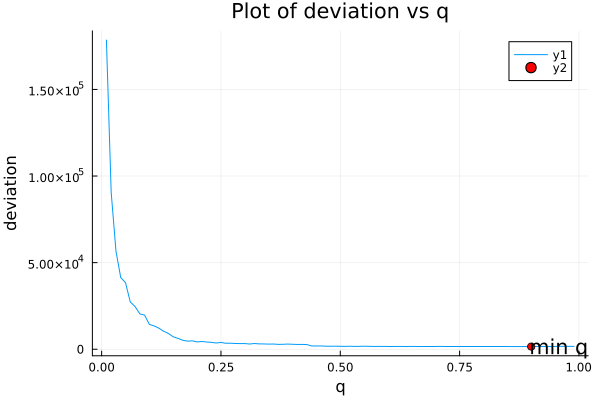

In [23]:
min_index = argmin(k)
min_q = q_values[min_index]
min_t = k[min_index]
@info min_q
@info min_t
plot(q_values, k, xlabel="q", ylabel="deviation", title="Plot of deviation vs q")
annotate!(min_q, min_t, text("min q", :left))
scatter!([min_q], [min_t], color=:red, marker=:circle)